In [146]:
# notebooks use their location as their working directory, so
# if we are in a subfolder, move to the main folder.  
# This however can safely be run multiple times
#setwd("M:/lecospec/lecospec")
if(!dir.exists("Functions/")){
    setwd("../")
    if(!dir.exists("Functions")){
        setwd("M:/lecospec/lecospec/")
    }
}
source("Functions/lecospectR.R", echo = FALSE)
library(class)
library(caret)
library(vegan)

## Load the Data

In [3]:
# spectral library
base_path <- "./Output/C_001_SC3_Cleaned_SpectralLib.csv"
veg_index_path <- "./Data/D_002_SpecLib_Derivs.csv"
speclib <- read.csv(base_path)
veg_indices <- read.csv(veg_index_path)

In [167]:
dim(veg_indices)

[1] 1343  249

In [168]:
head(veg_indices)

,ScanID,Area,Code_name,Species_name,Functional_group1,Functional_group2,Species_name_Freq,Functional_group1_Freq,Functional_group2_Freq,Genus,⋯,X947.593_5nm,X952.593_5nm,X957.593_5nm,X962.593_5nm,X967.593_5nm,X972.593_5nm,X977.593_5nm,X982.593_5nm,X987.593_5nm,X992.593_5nm
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,aleoch_Murph_061,Murphy,aleoch,Alectoria ochroleuca,Lichen,LightTerrestrialMacrolichen,6,453,118,Alectoria,⋯,26.59656,26.71230,26.78679,26.84674,26.92454,27.04128,27.20405,27.38601,27.55660,27.69153
2,aleoch_Murph_063,Murphy,aleoch,Alectoria ochroleuca,Lichen,LightTerrestrialMacrolichen,6,453,118,Alectoria,⋯,21.41355,21.52685,21.62140,21.70847,21.80113,21.90688,22.02912,22.16226,22.29784,22.42359
3,aleoch_Murph_064,Murphy,aleoch,Alectoria ochroleuca,Lichen,LightTerrestrialMacrolichen,6,453,118,Alectoria,⋯,31.84974,31.90839,31.98678,32.05158,32.08263,32.12036,32.19709,32.29237,32.38387,32.46974
4,aleoch_Murph_065,Murphy,aleoch,Alectoria ochroleuca,Lichen,LightTerrestrialMacrolichen,6,453,118,Alectoria,⋯,34.18603,34.21727,34.23974,34.25062,34.25074,34.25434,34.27278,34.30264,34.34254,34.40410
5,aleoch_Murph_066,Murphy,aleoch,Alectoria ochroleuca,Lichen,LightTerrestrialMacrolichen,6,453,118,Alectoria,⋯,29.14092,29.20809,29.27031,29.31446,29.34322,29.40614,29.53721,29.70353,29.86498,29.99403
6,alnfru_00003,Yukon_Delta,alnfru,Alnus sp.,ShrubDecid,ShrubAlder,82,360,82,Alnus,⋯,47.87045,47.74562,47.59385,47.48448,47.45815,47.44645,47.39159,47.31926,47.26754,47.26835


In [4]:
# Targets 
targets <- veg_indices[!is.na(veg_indices$Functional_group1),"Functional_group1"] %>% as.factor()
# weights
weights_by_pft <- targets_to_weights(targets)

In [5]:
# image-based validation
uav_speclib_df <- read.csv(
    "Data/Ground_Validation/PFT_image_spectra/PFT_Image_SpectralLib_Clean_unsmoothed.csv",
    header = TRUE)
image_validation <- uav_speclib_df[,16:(ncol(uav_speclib_df) - 1)]
validation_labels <- uav_speclib_df$FncGrp1 %>% as.factor()
#levels(validation_labels) <- c(levels(validation_labels), "Forb") 

## Base transformation
This removes infinity, outliers and NAs from the data.  

[1] "Imputing..."
[1] "Imputing..."


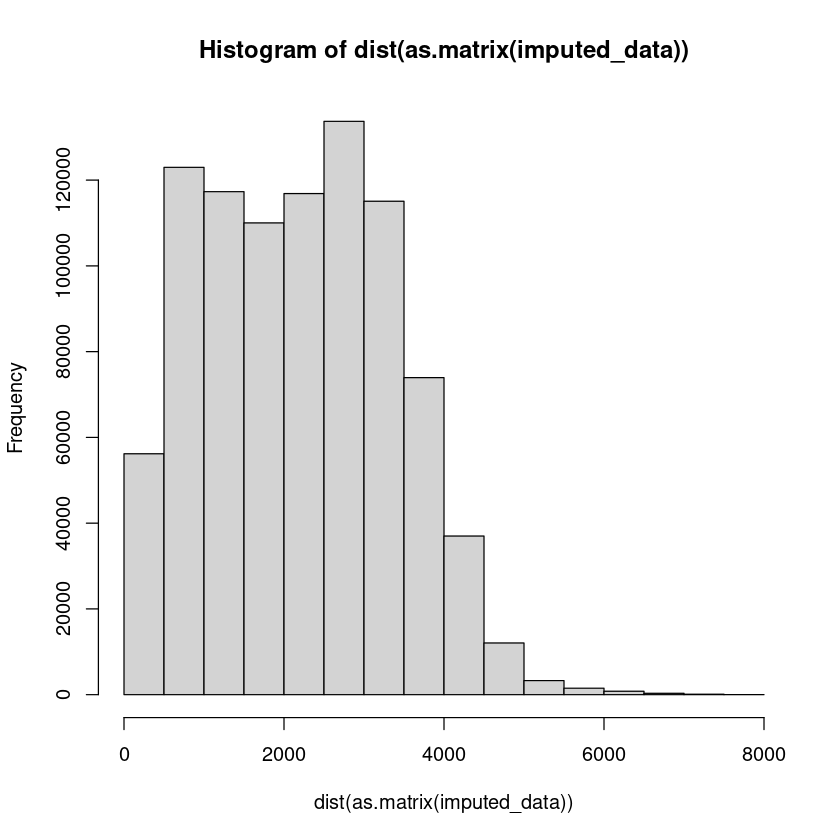

In [6]:
numeric_data <- veg_indices[!is.na(veg_indices$Functional_group1),35:(ncol(veg_indices)-1)]
numeric_data <- inf_to_na(numeric_data)
imputed_data_1 <- impute_spectra(numeric_data)
imputed_data_no_outliers <- outliers_to_na(imputed_data_1)
imputed_data <- impute_spectra(imputed_data_no_outliers)
outlier_indices <- detect_outliers_columnwise(imputed_data[,1:95])
filtered_data <- imputed_data[!outlier_indices,]
hist(dist(as.matrix(imputed_data)))
min_max_scaled_data <- columnwise_min_max_scale(imputed_data)

In [7]:
print(colnames(imputed_data))

  [1] "Boochs"       "Boochs2"      "CARI"         "Carter"       "Carter2"     
  [6] "Carter3"      "Carter4"      "Carter5"      "Carter6"      "CI"          
 [11] "CI2"          "ClAInt"       "CRI1"         "CRI2"         "CRI3"        
 [16] "CRI4"         "D1"           "D2"           "Datt"         "Datt2"       
 [21] "Datt3"        "Datt4"        "Datt5"        "Datt6"        "DD"          
 [26] "DDn"          "DPI"          "DWSI4"        "EGFN"         "EGFR"        
 [31] "EVI"          "GDVI2"        "GDVI3"        "GDVI4"        "GI"          
 [36] "Gitelson"     "Gitelson2"    "GMI1"         "GMI2"         "GreenNDVI"   
 [41] "Maccioni"     "MCARI"        "MCARIOSAVI"   "MCARI2"       "MCARI2OSAVI2"
 [46] "mND705"       "mNDVI"        "MPRI"         "MSAVI"        "mSR"         
 [51] "mSR2"         "mSR705"       "MTCI"         "MTVI"         "NDVI"        
 [56] "NDVI2"        "NDVI3"        "NPCI"         "OSAVI"        "OSAVI2"      
 [61] "PARS"         "PRI"  

## Transform the Image-based Data

In [8]:
veg_index_names <- read.csv("assets/vegIndicesUsed.csv")$x
validation_indices <- get_vegetation_indices(image_validation, NULL)
# drop NAs

validation_indices <- inf_to_na(validation_indices)
validation_indices <- impute_spectra(validation_indices)
validation_indices <- outliers_to_na(validation_indices)
validation_indices <- impute_spectra(validation_indices)


min_max_scaled_validation <- columnwise_min_max_scale(validation_indices)

#hist(as.matrix(min_max_scaled_validation))

[1] "Imputing..."
[1] "Imputing..."


In [9]:
validation_bands <- resample_df(image_validation,normalize = FALSE)

Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



In [124]:
head(validation_bands*100)
head(imputed_data)

,X397.593,X399.444,X401.296,X403.148,X405,X406.851,X408.703,X410.555,X412.407,X414.258,⋯,X947.593_5nm,X952.593_5nm,X957.593_5nm,X962.593_5nm,X967.593_5nm,X972.593_5nm,X977.593_5nm,X982.593_5nm,X987.593_5nm,X992.593_5nm
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6.23051450,3.506212,3.528830,2.388643,4.175193,4.444737,3.506006,3.792686,4.382252,3.809049,⋯,60.36375,40.63702,38.02218,50.83231,31.67423,46.07920,56.31738,35.92004,46.91269,55.45803
2,4.00123186,1.796218,3.851847,3.721397,3.060323,3.741900,3.648199,4.443201,3.350573,2.184333,⋯,46.86465,46.24053,45.67180,45.30919,45.25627,45.56505,45.96950,46.24647,46.44714,46.58802
3,0.84043005,3.238257,3.204808,3.776217,1.363567,4.305964,1.815413,3.225661,3.133865,1.530119,⋯,50.57998,50.53646,50.34268,50.06878,49.77038,49.37577,48.79545,48.07024,47.38714,46.91776
4,3.08196507,2.693668,2.982640,3.826822,2.772806,3.496188,2.686276,3.610758,3.194825,2.595915,⋯,56.12015,53.17520,46.41543,42.88708,44.16515,48.44522,49.00934,45.80274,42.90986,44.33307
5,0.00000000,3.137747,3.173570,4.546582,1.901339,5.601602,4.021830,2.270115,2.718437,2.712400,⋯,46.05991,44.81366,43.76937,43.05552,42.66201,42.54544,42.60648,42.83036,43.22142,43.67655
6,0.01645217,5.237276,3.943107,3.573843,3.348325,5.601602,3.531303,2.479458,3.284857,2.890707,⋯,58.48684,55.19830,48.56685,64.83222,32.73928,58.34752,74.14353,46.87937,43.45461,56.43954


,Boochs,Boochs2,CARI,Carter,Carter2,Carter3,Carter4,Carter5,Carter6,CI,⋯,X942.593_5nm,X947.593_5nm,X952.593_5nm,X957.593_5nm,X962.593_5nm,X967.593_5nm,X972.593_5nm,X977.593_5nm,X982.593_5nm,X987.593_5nm
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1817917,0.1007417,38.29230,4.176483,0.7481783,0.6363165,0.8663692,1.117048,13.0818,1.0250352,⋯,26.46858,26.59656,26.71230,26.78679,26.84674,26.92454,27.04128,27.20405,27.38601,27.55660
2,0.1779167,0.1020167,28.80530,2.891436,0.7004412,0.6404789,0.8394989,1.101463,11.0986,1.0235607,⋯,21.29147,21.41355,21.52685,21.62140,21.70847,21.80113,21.90688,22.02912,22.16226,22.29784
3,0.2774667,0.1313083,51.02598,4.620200,0.7542897,0.7048361,0.8855345,1.091549,19.9382,1.0258505,⋯,31.79622,31.84974,31.90839,31.98678,32.05158,32.08263,32.12036,32.19709,32.29237,32.38387
4,0.3004500,0.1415583,53.56754,4.666115,0.7373047,0.6970615,0.8696484,1.085199,21.6759,1.0229248,⋯,34.14242,34.18603,34.21727,34.23974,34.25062,34.25074,34.25434,34.27278,34.30264,34.34254
5,0.2610000,0.1341917,45.44606,4.686466,0.7357233,0.6848281,0.8729010,1.083553,17.5634,1.0207577,⋯,29.07701,29.14092,29.20809,29.27031,29.31446,29.34322,29.40614,29.53721,29.70353,29.86498
6,0.9367000,1.1057000,33.48758,1.427278,0.1320466,0.1048420,0.4051465,1.673969,9.2749,0.9921833,⋯,47.95642,47.87045,47.74562,47.59385,47.48448,47.45815,47.44645,47.39159,47.31926,47.26754


In [10]:
print(colnames(validation_bands))

  [1] "X397.593"     "X399.444"     "X401.296"     "X403.148"     "X405"        
  [6] "X406.851"     "X408.703"     "X410.555"     "X412.407"     "X414.258"    
 [11] "X416.11"      "X417.962"     "X419.814"     "X421.666"     "X423.517"    
 [16] "X425.369"     "X427.221"     "X429.073"     "X430.924"     "X432.776"    
 [21] "X434.628"     "X436.48"      "X438.332"     "X440.183"     "X442.035"    
 [26] "X443.887"     "X445.739"     "X447.59"      "X449.442"     "X451.294"    
 [31] "X453.146"     "X454.998"     "X456.849"     "X458.701"     "X460.553"    
 [36] "X462.405"     "X464.256"     "X466.108"     "X467.96"      "X469.812"    
 [41] "X471.664"     "X473.515"     "X475.367"     "X477.219"     "X479.071"    
 [46] "X480.922"     "X482.774"     "X484.626"     "X486.478"     "X488.33"     
 [51] "X490.181"     "X492.033"     "X493.885"     "X495.737"     "X497.588"    
 [56] "X499.44"      "X501.292"     "X503.144"     "X504.996"     "X506.847"    
 [61] "X508.699"     "X510.5

In [11]:
image_weights <- targets_to_weights(validation_labels %>% as.factor())

## PCA 
This is where we calcuate PCA for the ground and image spectra

Importance of components:
                             PC1       PC2       PC3      PC4      PC5      PC6
Standard deviation     3300.5440 1330.7311 346.42416 182.6024 38.97262 27.68928
Proportion of Variance    0.8497    0.1381   0.00936   0.0026  0.00012  0.00006
Cumulative Proportion     0.8497    0.9878   0.99713   0.9997  0.99985  0.99991
                            PC7      PC8      PC9    PC10 PC11  PC12  PC13
Standard deviation     21.91225 17.68733 10.16916 8.10533 6.35 6.085 5.902
Proportion of Variance  0.00004  0.00002  0.00001 0.00001 0.00 0.000 0.000
Cumulative Proportion   0.99994  0.99997  0.99998 0.99998 1.00 1.000 1.000
                        PC14  PC15  PC16  PC17  PC18  PC19  PC20  PC21  PC22
Standard deviation     4.696 4.437 4.126 3.771 3.234 2.846 2.675 2.251 2.053
Proportion of Variance 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
Cumulative Proportion  1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000
                        PC23  PC24  PC25  PC26

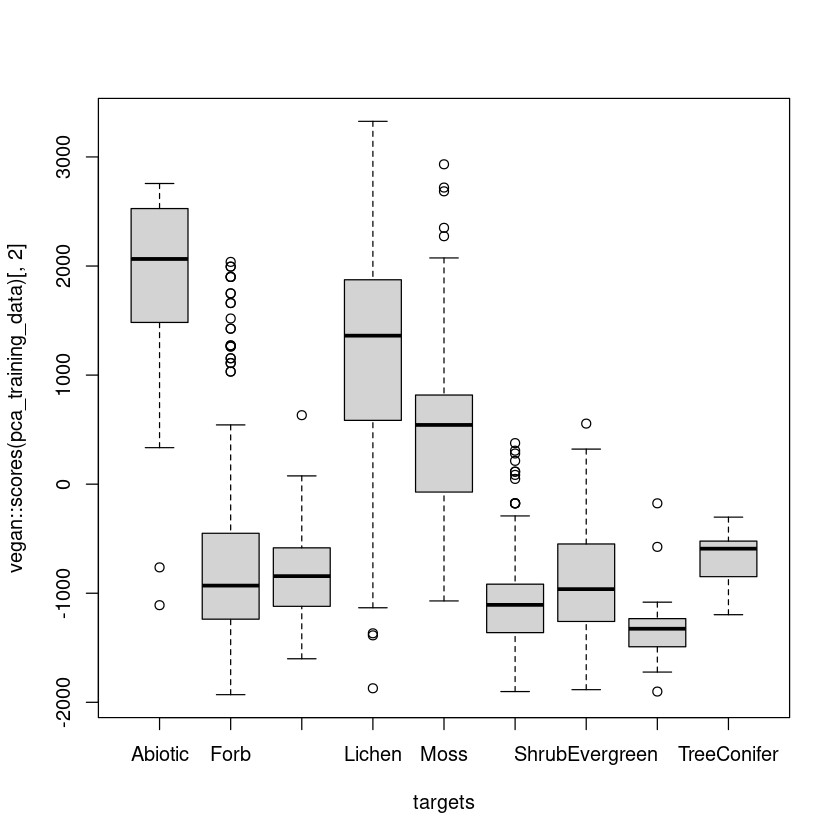

In [12]:
# fit a PCA to the ground spectra
pca_fit <- stats::prcomp(imputed_data[,1:(ncol(numeric_data) - 66)], center = FALSE, scale. = FALSE)
print(summary(pca_fit))
pca_training_data <- predict(pca_fit, imputed_data[,1:(ncol(numeric_data) - 66)])[,1:64]
boxplot(vegan::scores(pca_training_data)[,2]~targets)

## Standardization
This cell standardizes the input to center at zero with standard deviation one.

In [13]:
# standardization
indice_standardizer <- caret::preProcess(imputed_data[,1:95])
standardized_indices <- predict(indice_standardizer, imputed_data[,1:95])

val_standardizer <- caret::preProcess(validation_indices)
standardized_validation <- predict(val_standardizer, validation_indices)

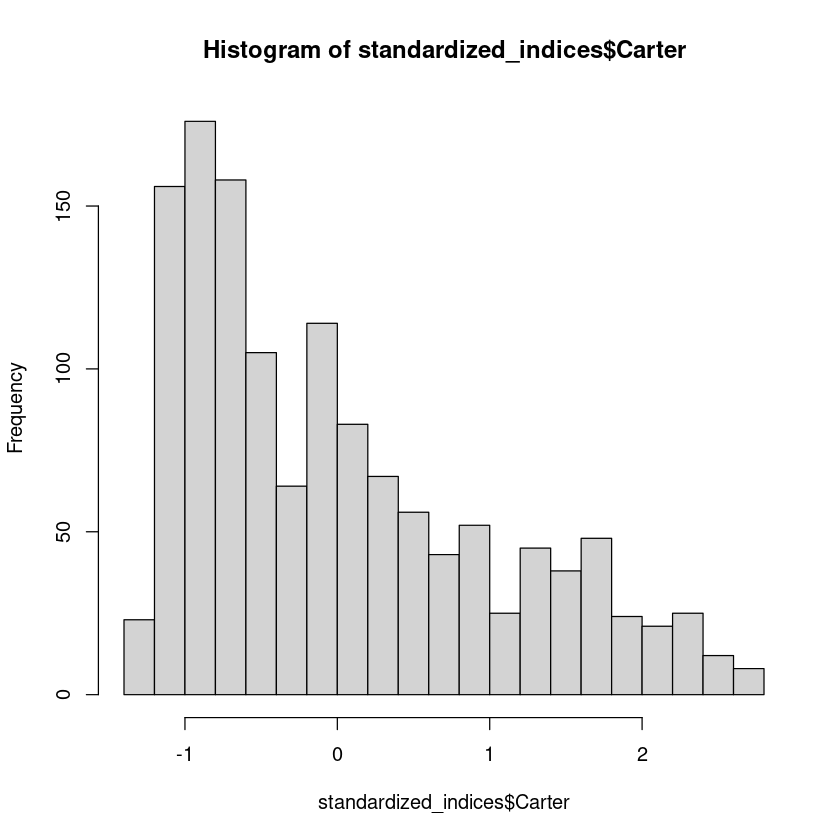

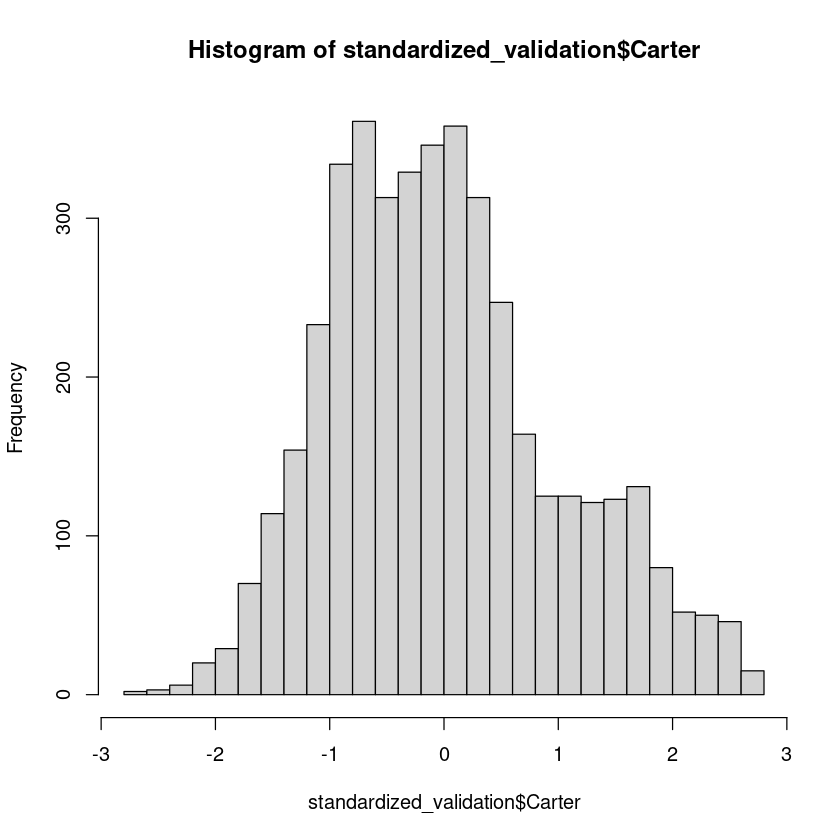

In [14]:
hist(standardized_indices$Carter, breaks = 20)
hist(standardized_validation$Carter, breaks = 20)

## Min-Max Scaling
This executes the min-man scalaing (to make the data on the scale [0,1])

In [15]:
# plots
#hist(min_max_scaled_validation %>% as.matrix())
#hist(min_max_scaled_data %>% as.matrix())
print(colnames(validation_indices))
print(str(pca_fit))
#pca_validation_data <- predict(pca_fit, validation_indices)[,1:64] %>% as.data.frame()
#boxplot(vegan::scores(pca_validation_data)[,2]~validation_labels)

 [1] "Boochs"       "Boochs2"      "CARI"         "Carter"       "Carter2"     
 [6] "Carter3"      "Carter4"      "Carter5"      "Carter6"      "CI"          
[11] "CI2"          "ClAInt"       "CRI1"         "CRI2"         "CRI3"        
[16] "CRI4"         "D1"           "D2"           "Datt"         "Datt2"       
[21] "Datt3"        "Datt4"        "Datt5"        "Datt6"        "DD"          
[26] "DDn"          "DPI"          "DWSI4"        "EGFN"         "EGFR"        
[31] "EVI"          "GDVI2"        "GDVI3"        "GDVI4"        "GI"          
[36] "Gitelson"     "Gitelson2"    "GMI1"         "GMI2"         "GreenNDVI"   
[41] "Maccioni"     "MCARI"        "MCARIOSAVI"   "MCARI2"       "MCARI2OSAVI2"
[46] "mND705"       "mNDVI"        "MPRI"         "MSAVI"        "mSR"         
[51] "mSR2"         "mSR705"       "MTCI"         "MTVI"         "NDVI"        
[56] "NDVI2"        "NDVI3"        "NPCI"         "OSAVI"        "OSAVI2"      
[61] "PARS"         "PRI"          "PRIC

## KS Tests of Transferrability
These next few cells test whether the veg indices are similarly distributed (i.e. could be samples drawn from the same distribution)

The hypothesis is that columns (veg indices) that pass this test can safely be used across models and conditions (are transferrable)

In [165]:
source("Functions/lecospectR.R")
ks_test_results <- test_transferrability(matched_data$left, matched_data$right)
print(ks_test_results)

Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate

$Boochs

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.96429, p-value < 2.2e-16
alternative hypothesis: two-sided


$Boochs2

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.91071, p-value < 2.2e-16
alternative hypothesis: two-sided


$CARI

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 1, p-value < 2.2e-16
alternative hypothesis: two-sided


$Carter

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.31696, p-value = 3.369e-10
alternative hypothesis: two-sided


$Carter2

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.22321, p-value = 2.844e-05
alternative hypothesis: two-sided


$Carter3

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.21875, p-value = 4.425e-05
alternative hypothesis: two-sided


$Carter4

	Asymptotic two-sample Kolmogorov-Smirnov test


## t-SNE
Examine the clusters in the data via *t*-SNE

 [1] "N"                   "Y"                   "costs"              
 [4] "itercosts"           "origD"               "perplexity"         
 [7] "theta"               "max_iter"            "stop_lying_iter"    
[10] "mom_switch_iter"     "momentum"            "final_momentum"     
[13] "eta"                 "exaggeration_factor"


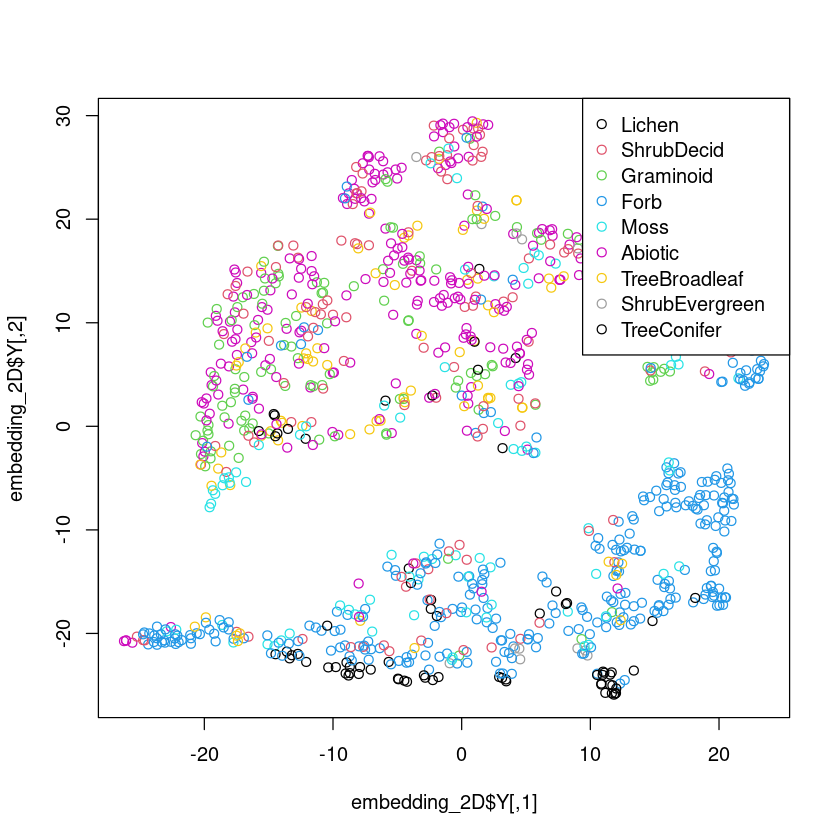

In [17]:
library(Rtsne)
unique_indices <- imputed_data[!duplicated(imputed_data),1:95]
normalized_veg_indices <- Rtsne::normalize_input(
    unique_indices %>% 
    as.matrix()
    )
embedding_2D <- Rtsne::Rtsne(normalized_veg_indices)
print(names(embedding_2D))

plot(embedding_2D$Y, col = as.factor(targets))
par(xpd=T)
legend("topright", legend = unique(targets), col = seq_along(unique(targets)),pch = 1)

## Vector Quantization Classifier
This fits a LVQ classifier to the data and then 

In [18]:
print(length(validation_labels))
print(nrow(min_max_scaled_validation))

[1] 4264
[1] 4264


## Train-Test Split

Perform an 80-20 split on the data (use the split on the fly during the grid search)

In [19]:
grd_train_idx <- caTools::sample.split(targets, SplitRatio = 0.8)

In [20]:
img_train_idx <- caTools::sample.split(validation_labels, SplitRatio = 0.8)

## Random Forest
trains a random forest model

In [21]:

rf_model <- ranger::ranger(
    num.trees = 256,
    case.weights = image_weights,
    importance = "impurity",
    classification = TRUE,
    x = validation_indices,
    y = validation_labels
)

print(rf_model)

Ranger result

Call:
 ranger::ranger(num.trees = 256, case.weights = image_weights,      importance = "impurity", classification = TRUE, x = validation_indices,      y = validation_labels) 

Type:                             Classification 
Number of trees:                  256 
Sample size:                      4264 
Number of independent variables:  95 
Mtry:                             9 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             3.95 % 


In [22]:
predictions <- predict(rf_model, validation_indices)$predictions %>% 
    as.factor()
confusion_matrix <- caret::confusionMatrix(
    predictions, 
    validation_labels, 
    mode = "everything")
print(confusion_matrix)

Confusion Matrix and Statistics

                Reference
Prediction       Abiotic Graminoid Lichen Moss ShrubDecid ShrubEvergreen
  Abiotic            820         0      0    0          0              0
  Graminoid            0       145      0    0          0              0
  Lichen               0         0    155    0          0              0
  Moss                 0         0      0   31          0              0
  ShrubDecid           0         0      0    0        129              0
  ShrubEvergreen       0         0      0    0          0            222
  TreeBroadleaf        0         0      0    0          0              0
  TreeConifer          0         0      0    0          0              0
                Reference
Prediction       TreeBroadleaf TreeConifer
  Abiotic                    0           0
  Graminoid                  0          11
  Lichen                     0           0
  Moss                       0           0
  ShrubDecid                 0           1


In [23]:
save(rf_model, file="mle/models/gs/rf_base_2.rda")

In [24]:
important_variables <- sort(rf_model$variable.importance, decreasing = TRUE)
print(important_variables)

      mSR705       mND705         PSND          SR2         PARS    GreenNDVI 
  122.756580   117.170965   104.542881   102.022084    91.344647    75.851293 
        GMI2        NDVI2         mSR2       ClAInt          TVI          SR7 
   75.154995    72.100340    66.645604    66.562561    65.936467    64.974710 
      OSAVI2          SR1    Gitelson2          SR8         CRI2         Datt 
   63.394800    61.189390    60.277910    58.851678    58.356386    57.858485 
     Carter6         SPVI         MTCI          SR3         GMI1       SumDr2 
   57.854242    55.937888    55.883607    55.587981    55.364497    55.153949 
      Carter     Maccioni MCARI2OSAVI2         PSSR           SR         SRPI 
   54.928407    54.925801    54.590795    54.246538    51.934680    51.399023 
         SR6      Carter3       MCARI2          CI2      Carter2        NDVI3 
   51.030222    48.310107    48.033092    47.720768    47.489354    47.087369 
       DWSI4    Vogelmann         MTVI TCARI2OSAVI2 

In [25]:
important_variable_names<- names(important_variables)
print(important_variable_names)

 [1] "mSR705"       "mND705"       "PSND"         "SR2"          "PARS"        
 [6] "GreenNDVI"    "GMI2"         "NDVI2"        "mSR2"         "ClAInt"      
[11] "TVI"          "SR7"          "OSAVI2"       "SR1"          "Gitelson2"   
[16] "SR8"          "CRI2"         "Datt"         "Carter6"      "SPVI"        
[21] "MTCI"         "SR3"          "GMI1"         "SumDr2"       "Carter"      
[26] "Maccioni"     "MCARI2OSAVI2" "PSSR"         "SR"           "SRPI"        
[31] "SR6"          "Carter3"      "MCARI2"       "CI2"          "Carter2"     
[36] "NDVI3"        "DWSI4"        "Vogelmann"    "MTVI"         "TCARI2OSAVI2"
[41] "Gitelson"     "EVI"          "NPCI"         "Datt6"        "TCARI2"      
[46] "GI"           "GDVI3"        "Datt5"        "OSAVI"        "RDVI"        
[51] "SAVI"         "MPRI"         "MSAVI"        "NDVI"         "CRI1"        
[56] "CRI4"         "GDVI4"        "TGI"          "Vogelmann2"   "CRI3"        
[61] "CARI"         "GDVI2"        "DDn"

In [125]:
# generate the test data
set.seed(61718L)
permutation <- permute::shuffle(validation_labels)
val_t_chars <- validation_labels[permutation] %>% as.character()
print(val_t_chars[1:5])
counts <- c(0,0,0,0,0,0,0,0,0)
samples <- vector(mode = "logical", length=length(validation_labels))

for(i in seq_along(val_t_chars)){
    samples[[i]] <- FALSE
    if(val_t_chars[[i]] == "Abiotic"){
        if(counts[[1]]<31){
            samples[[i]] <-  TRUE
            counts[[1]] <- counts[[1]] + 1
        }

    } else if (val_t_chars[[i]] == "Graminoid"){
        if(counts[[2]] < 31){
            samples[[i]] <-  TRUE
            counts[[2]] <- counts[[2]] + 1
        }
    } else if (val_t_chars[[i]] == "Forb"){
        if(counts[[3]] < 31){
            samples[[i]] <-  TRUE
            counts[[3]] <- counts[[3]] + 1
        }
    } else if (val_t_chars[[i]] == "Lichen"){
        if(counts[[4]] < 31){
            samples[[i]] <-  TRUE
            counts[[4]] <- counts[[4]] + 1
        }
    } else if (val_t_chars[[i]] == "Moss"){
        if(counts[[5]] < 31){
            samples[[i]] <-  TRUE
            counts[[5]] <- counts[[5]] + 1
        }
    } else if (val_t_chars[[i]] == "ShrubDecid"){
        if(counts[[6]] < 31){
            samples[[i]] <-  TRUE
            counts[[6]] <- counts[[6]] + 1
        }
    } else if (val_t_chars[[i]] == "ShrubEvergreen"){
        if(counts[[7]] < 31){
            samples[[i]] <-  TRUE
            counts[[7]] <- counts[[7]] + 1
        }
    } else if (val_t_chars[[i]] == "TreeConifer"){
        if(counts[[8]] < 31){
            samples[[i]] <-  TRUE
            counts[[8]] <- counts[[8]] + 1
        }
    } else if (val_t_chars[[i]] == "TreeBroadleaf"){
        if(counts[[9]] < 31){
            samples[[i]] <-  TRUE
            counts[[9]] <- counts[[9]] + 1
        }
    }
}


temp <- validation_labels[permutation] %>% as.factor()
test_labels <- temp[as.vector(samples)]
temp <- cbind(validation_indices[permutation,], 100*validation_bands[permutation,]) %>% as.data.frame()
test_data <- temp[as.vector(samples),]



[1] "Lichen"         "TreeConifer"    "TreeConifer"    "ShrubEvergreen"
[5] "TreeConifer"   


In [126]:
print(test_labels %>% table())

.
       Abiotic      Graminoid         Lichen           Moss     ShrubDecid 
            31             31             31             31             31 
ShrubEvergreen  TreeBroadleaf    TreeConifer 
            31             31             31 


In [127]:
# generate the test data
set.seed(61718L)
permutation <- permute::shuffle(targets)
val_t_chars <- targets[permutation] %>% as.character()
print(val_t_chars[1:5])
counts <- c(0,0,0,0,0,0,0,0,0)
samples <- vector(mode = "logical", length=length(targets))

for(i in seq_along(val_t_chars)){
    samples[[i]] <- FALSE
    if(val_t_chars[[i]] == "Abiotic"){
        if(counts[[1]]<31){
            samples[[i]] <-  TRUE
            counts[[1]] <- counts[[1]] + 1
        }

    } else if (val_t_chars[[i]] == "Graminoid"){
        if(counts[[2]] < 31){
            samples[[i]] <-  TRUE
            counts[[2]] <- counts[[2]] + 1
        }
    } else if (val_t_chars[[i]] == "Forb"){
        if(counts[[3]] < 31){
            samples[[i]] <-  TRUE
            counts[[3]] <- counts[[3]] + 1
        }
    } else if (val_t_chars[[i]] == "Lichen"){
        if(counts[[4]] < 31){
            samples[[i]] <-  TRUE
            counts[[4]] <- counts[[4]] + 1
        }
    } else if (val_t_chars[[i]] == "Moss"){
        if(counts[[5]] < 31){
            samples[[i]] <-  TRUE
            counts[[5]] <- counts[[5]] + 1
        }
    } else if (val_t_chars[[i]] == "ShrubDecid"){
        if(counts[[6]] < 31){
            samples[[i]] <-  TRUE
            counts[[6]] <- counts[[6]] + 1
        }
    } else if (val_t_chars[[i]] == "ShrubEvergreen"){
        if(counts[[7]] < 31){
            samples[[i]] <-  TRUE
            counts[[7]] <- counts[[7]] + 1
        }
    } else if (val_t_chars[[i]] == "TreeConifer"){
        if(counts[[8]] < 31){
            samples[[i]] <-  TRUE
            counts[[8]] <- counts[[8]] + 1
        }
    } else if (val_t_chars[[i]] == "TreeBroadleaf"){
        if(counts[[9]] < 31){
            samples[[i]] <-  TRUE
            counts[[9]] <- counts[[9]] + 1
        }
    }
}


temp <- targets[permutation] %>% as.factor()
train_labels <- temp[as.vector(samples)]
temp <- imputed_data[permutation,] %>% as.data.frame()
train_data <- temp[as.vector(samples),]


[1] "Lichen"     "Lichen"     "Abiotic"    "Graminoid"  "ShrubDecid"


In [128]:
# match the samples between the data and create a matched dataset
joined_train <- train_data
joined_train$targets <- train_labels

joined_test <- test_data
joined_test$targets <- test_labels




In [166]:
create_matched_data <- function(left_df, right_df, cols = c("targets", "targets")){
    
    shared_levels <- intersect(
        levels(as.factor(left_df[, cols[1]])), 
        levels(as.factor(right_df[, cols[[2]]]))
        )

    # store inermediate results in a list
    level_dfs_l <- NULL
    level_dfs_r <- NULL

    for( level in shared_levels){
        filtered_left <- left_df[(left_df[,cols[[1]]] == level),]
        filtered_right <- right_df[right_df[,cols[[2]]] == level,]

        permutation_left <- permute::shuffle(nrow(filtered_left))
        permutation_right <- permute::shuffle(nrow(filtered_right))

        num_records <- min(nrow(filtered_left), nrow(filtered_right))
        
        if(num_records > 0){
            if(is.null(level_dfs_l)){
                level_dfs_l <- filtered_left[1:num_records,]
            } else {
                level_dfs_l <- rbind(level_dfs_l, filtered_left[permutation_left[1:num_records],])
            }

            if(is.null(level_dfs_r)){
                level_dfs_r <- filtered_right[1:num_records,]
            } else {
                level_dfs_r <- rbind(level_dfs_r, filtered_right[permutation_right[1:num_records],])
            }

        }
    }

    return(list(
        left = level_dfs_l,
        right = level_dfs_r
    ))


}

In [130]:
matched_data <- create_matched_data(
    joined_test %>% as.data.frame(),
    joined_train %>% as.data.frame()
)

In [131]:
head(matched_data$left)

,Boochs,Boochs2,CARI,Carter,Carter2,Carter3,Carter4,Carter5,Carter6,CI,⋯,X952.593_5nm,X957.593_5nm,X962.593_5nm,X967.593_5nm,X972.593_5nm,X977.593_5nm,X982.593_5nm,X987.593_5nm,X992.593_5nm,targets
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3465,0.0007439020,-0.011755521,0.3714853,2.548838,0.6278374,0.4998647,0.7621990,1.1644684,0.1315885,0.8790975,⋯,38.66041,44.18000,14.68119,26.25009,47.05269,19.80092,32.47951,40.56652,13.40072,Abiotic
3433,0.0011766963,-0.003707181,0.3870249,2.714261,0.6386688,0.5020051,0.8359541,1.1543293,0.1309489,0.8281901,⋯,27.86249,28.26297,28.68145,29.11826,29.57295,30.04275,30.52319,31.01094,31.50370,Abiotic
3120,0.0072719852,-0.011170256,0.4565644,2.584118,0.6426221,0.5043425,0.8296320,1.1045128,0.1284355,0.9457176,⋯,25.69281,25.66784,25.64385,25.62078,25.59855,25.57716,25.55647,25.53618,25.51621,Abiotic
3403,0.0055075102,-0.006805719,0.4036135,2.608930,0.6341930,0.5017488,0.8452350,1.0677134,0.1300941,0.9699125,⋯,22.00584,26.39804,30.41077,31.74072,30.41763,27.48110,24.42119,22.39946,19.48607,Abiotic
2871,-0.0008970325,0.002176682,0.3463395,2.123116,0.6418764,0.5023841,0.8834467,0.9754347,0.1366540,0.9584139,⋯,21.29749,21.33707,21.37613,21.41478,21.45308,21.49104,21.52871,21.56611,21.60326,Abiotic
296,0.0015011914,-0.004418960,0.2873858,1.701350,0.6276401,0.5114808,0.8931185,1.0030919,0.1088389,1.0211379,⋯,14.84993,14.81298,14.77644,14.74030,14.70440,14.66866,14.63298,14.59724,14.56133,Abiotic


In [132]:
head(matched_data$right)

,Boochs,Boochs2,CARI,Carter,Carter2,Carter3,Carter4,Carter5,Carter6,CI,⋯,X947.593_5nm,X952.593_5nm,X957.593_5nm,X962.593_5nm,X967.593_5nm,X972.593_5nm,X977.593_5nm,X982.593_5nm,X987.593_5nm,targets
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
117,0.03775833,0.02080833,30.07723,1.9977528,0.9212018,0.8454049,0.9535463,1.0558815,12.05520,1.013691,⋯,16.53509,16.54344,16.55310,16.56559,16.58350,16.61323,16.65639,16.69933,16.73294,Abiotic
371,0.75680833,0.53616667,63.47348,5.2963068,0.4141177,0.2651888,0.6700781,1.6290539,10.95620,1.138685,⋯,47.73061,47.61511,47.50213,47.40171,47.32321,47.27690,47.26454,47.26346,47.25979,Abiotic
823,0.15052500,0.14780833,64.53759,3.6317042,0.7887494,0.6936495,0.8451258,1.0873595,16.89500,1.000075,⋯,32.22922,32.41554,32.59834,32.78824,33.00424,33.27274,33.60386,33.95830,34.30669,Abiotic
376,1.02815000,1.05225000,46.67439,1.8229583,0.1475743,0.1215896,0.4468919,1.9992375,10.80680,1.089778,⋯,48.19229,47.95009,47.69486,47.48710,47.36087,47.26083,47.14032,47.02107,46.93758,Abiotic
369,0.39525833,0.29743333,69.71882,5.3003579,0.6351469,0.3500210,0.7763064,1.3311888,11.14870,1.051380,⋯,51.10833,51.05461,51.01108,50.97075,50.92805,50.89623,50.88446,50.88129,50.88214,Abiotic
825,0.00912500,-0.03050833,111.24241,0.9734296,1.0057524,1.0197222,1.0079005,0.9961795,18.54124,1.000494,⋯,67.29571,67.24874,67.18330,67.13613,67.16002,67.32647,67.66136,68.05292,68.37651,Abiotic


In [133]:
write_tukey_symmetric_difference_plots <- function(
    left_df,
    right_df,
    save_directory = "./", 
    ignore_cols = NULL
) {
    used_cols <- intersect(
        colnames(left_df),
        colnames(right_df)
    )

    if(!is.null(ignore_cols)){
        used_cols <- setdiff(used_cols, ignore_cols)
    }

    for(col in used_cols){
        y_l <- left_df[,col] 
        r_l <- right_df[,col]
        if(is.numeric(y_l) & is.numeric(r_l)){
            plt <- create_tukey_symmetric_difference_plot(
                y_l,r_l
            )
           ggsave(
            paste0(save_directory, col, ".png"),
            plot = plt
           ) 
        }



    }
}

In [134]:
create_tukey_symmetric_difference_plot <- function(
    left_vec,
    right_vec
) {
    average_vec <- (left_vec + right_vec) / 2
    difference_vec <- (left_vec - right_vec)

    min_average <- min(average_vec)
    max_average <- max(average_vec)

    sd_difference <- sd(difference_vec)
    mean_difference <- mean(difference_vec)
    upper_bound <- mean_difference + (1.96*sd_difference)
    lower_bound <- mean_difference - (1.96 * sd_difference)

    plt <- ggplot(
            data = NULL,
            aes(
                x=average_vec,
                y=difference_vec
            )
        ) +
        geom_point() + 
        geom_hline(
            yintercept=lower_bound,
            color="red"
        ) + 
        geom_hline(
            yintercept = upper_bound,
            color="red"
        ) +
        geom_hline(
            yintercept = mean_difference,
            color="blue"
        ) +
        ylab("Diff. Between Measures") +
        xlab("Average Measure")

    return(plt)
        
}

In [135]:
write_tukey_symmetric_difference_plots(
    matched_data$left,
    matched_data$right,
    save_directory = "figures/differencePlots/"
)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 

In [136]:
write_tukey_symmetric_difference_plots(
    standardize_df(matched_data$left,ignore_cols=c("targets")),
    standardize_df(matched_data$right,ignore_cols=c("targets")),
    save_directory = "figures/standardizedDifferences/"
)

write_tukey_symmetric_difference_plots(
    columnwise_min_max_scale(matched_data$left,ignore_cols=c("targets")),
    columnwise_min_max_scale(matched_data$right,ignore_cols=c("targets")),
    save_directory = "figures/minMaxDifferences/"
)

write_tukey_symmetric_difference_plots(
    columnwise_robust_scale(matched_data$left,ignore_cols=c("targets")),
    columnwise_robust_scale(matched_data$right,ignore_cols=c("targets")),
    save_directory = "figures/scaledDifferences/"
)


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 

In [103]:
build_columnwise_sensor_correction_model <- function(
    left_df, 
    right_df, 
    ignore_cols = NULL,
    verbose = TRUE
) {

    used_cols <- intersect(
        colnames(left_df),
        colnames(right_df)
    )

    if(!is.null(ignore_cols)){
        used_cols <- setdiff(used_cols, ignore_cols)
    }


    models  <- list()

    for(col in used_cols){
        left_vec <- sort(left_df[,col])
        right_vec <- sort(right_df[,col])
        if(is.numeric(left_vec) & is.numeric(right_vec)){
            model <- lm(
                left_vec~right_vec,
                )

            if(verbose){
                print(summary(model))
            }
            models[[col]] <- model
        }
    }

    return(models)
}

In [137]:
correction_models <- build_columnwise_sensor_correction_model(matched_data$left, matched_data$right)


Call:
lm(formula = left_vec ~ right_vec)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0061706 -0.0005335 -0.0001481  0.0006020  0.0023979 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0011338  0.0001533  -7.394 2.88e-12 ***
right_vec    0.0127376  0.0001893  67.286  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001171 on 222 degrees of freedom
Multiple R-squared:  0.9533,	Adjusted R-squared:  0.953 
F-statistic:  4527 on 1 and 222 DF,  p-value: < 2.2e-16


Call:
lm(formula = left_vec ~ right_vec)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0077386 -0.0009139 -0.0003507  0.0014898  0.0069123 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0048355  0.0002252  -21.47   <2e-16 ***
right_vec    0.0154683  0.0002847   54.33   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [138]:
apply_sensor_correction_model <- function(
    models,
    data,
    ignore_cols = NULL
){
    used_cols <- colnames(data)
     if(!is.null(ignore_cols)){
        used_cols <- setdiff(used_cols, ignore_cols)
    }

    df_corrected <- as.data.frame(data)

    for(col in used_cols){
        if(!is.null(models[[col]])){
            model_intercept <- summary(models[[col]])$coefficients[1,1]
            model_slope <- summary(models[[col]])$coefficients[2,1]
            df_corrected[,col] <- model_intercept + (data[,col]*model_slope)
        }
    }

    return(df_corrected)
}

In [139]:
transformed_data <- apply_sensor_correction_model(
    correction_models,
    imputed_data
)

head(transformed_data)
head(imputed_data)

,Boochs,Boochs2,CARI,Carter,Carter2,Carter3,Carter4,Carter5,Carter6,CI,⋯,X942.593_5nm,X947.593_5nm,X952.593_5nm,X957.593_5nm,X962.593_5nm,X967.593_5nm,X972.593_5nm,X977.593_5nm,X982.593_5nm,X987.593_5nm
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.001181837,-0.003277235,0.2267417,3.554431,0.5285856,0.4093939,0.7286466,1.082823,0.08190205,0.9445186,⋯,17.91997,18.01120,17.41286,17.65602,17.39469,18.21402,17.99003,18.16876,17.71674,17.68024
2,0.001132478,-0.003257513,0.1956466,2.963350,0.5031640,0.4112352,0.7106126,1.072875,0.07374752,0.9421395,⋯,15.76565,15.95345,15.21610,15.50558,15.06782,15.98815,15.58635,15.78795,15.12880,15.06692
3,0.002400509,-0.002804421,0.2684782,3.758527,0.5318401,0.4397051,0.7415094,1.066548,0.11009422,0.9458340,⋯,20.13694,20.09682,19.61414,19.82086,19.75171,20.45496,20.36781,20.46588,20.14746,20.07913
4,0.002693262,-0.002645871,0.2768085,3.779647,0.5227951,0.4362658,0.7308474,1.062494,0.11723930,0.9411135,⋯,21.11325,21.02437,20.59227,20.75880,20.74754,21.39689,21.36683,21.42083,21.14338,21.05248
5,0.002190763,-0.002759821,0.2501892,3.789007,0.5219529,0.4308541,0.7330304,1.061444,0.10032951,0.9376171,⋯,19.00540,19.02136,18.47018,18.68995,18.51220,19.26482,19.09714,19.24216,18.86489,18.82738
6,0.010797577,0.012267755,0.2109935,2.289884,0.2004751,0.1742842,0.4190963,1.438308,0.06624882,0.8915136,⋯,26.86161,26.45735,26.32343,26.31834,26.74051,27.13486,27.54274,27.45633,27.59208,27.47550


,Boochs,Boochs2,CARI,Carter,Carter2,Carter3,Carter4,Carter5,Carter6,CI,⋯,X942.593_5nm,X947.593_5nm,X952.593_5nm,X957.593_5nm,X962.593_5nm,X967.593_5nm,X972.593_5nm,X977.593_5nm,X982.593_5nm,X987.593_5nm
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1817917,0.1007417,38.29230,4.176483,0.7481783,0.6363165,0.8663692,1.117048,13.0818,1.0250352,⋯,26.46858,26.59656,26.71230,26.78679,26.84674,26.92454,27.04128,27.20405,27.38601,27.55660
2,0.1779167,0.1020167,28.80530,2.891436,0.7004412,0.6404789,0.8394989,1.101463,11.0986,1.0235607,⋯,21.29147,21.41355,21.52685,21.62140,21.70847,21.80113,21.90688,22.02912,22.16226,22.29784
3,0.2774667,0.1313083,51.02598,4.620200,0.7542897,0.7048361,0.8855345,1.091549,19.9382,1.0258505,⋯,31.79622,31.84974,31.90839,31.98678,32.05158,32.08263,32.12036,32.19709,32.29237,32.38387
4,0.3004500,0.1415583,53.56754,4.666115,0.7373047,0.6970615,0.8696484,1.085199,21.6759,1.0229248,⋯,34.14242,34.18603,34.21727,34.23974,34.25062,34.25074,34.25434,34.27278,34.30264,34.34254
5,0.2610000,0.1341917,45.44606,4.686466,0.7357233,0.6848281,0.8729010,1.083553,17.5634,1.0207577,⋯,29.07701,29.14092,29.20809,29.27031,29.31446,29.34322,29.40614,29.53721,29.70353,29.86498
6,0.9367000,1.1057000,33.48758,1.427278,0.1320466,0.1048420,0.4051465,1.673969,9.2749,0.9921833,⋯,47.95642,47.87045,47.74562,47.59385,47.48448,47.45815,47.44645,47.39159,47.31926,47.26754


# Grid Search

This next section defines all the essentials for the grid search across our different candidate models. 

## Candidates

### Models
* Random Forest
* Learned Vector Quantization (LVQ)
* k-Nearest Neighbor (kNN)

Could also consider Support Vector Machine (SVM), Gradient Boosted Trees (e.g. LightGBM, XGBoost), matched filtering, Logistic Regression, etc.

### Data/Transformations

For each of the image/training data sets, test the following:
* raw, 
* raw (no outliers)
* standardized (z-score standardization)
* standardized (z-score standardization, no outliers)
* min-max scaled
* min-max scaled (no outliers)
* PCA
* PCA no outliers

Need to also vary how many columns are included in the analysis

In [140]:
print(dim(imputed_data))
print(dim(standardized_indices))
print(dim(min_max_scaled_data))
print(dim(validation_indices))
print(dim(standardized_validation))
print(dim(min_max_scaled_validation))


[1] 1343  214
[1] 1343   95
[1] 1343  214
[1] 4264   95
[1] 4264   95
[1] 4264   95


In [29]:
print(colnames(imputed_data))

  [1] "Boochs"       "Boochs2"      "CARI"         "Carter"       "Carter2"     
  [6] "Carter3"      "Carter4"      "Carter5"      "Carter6"      "CI"          
 [11] "CI2"          "ClAInt"       "CRI1"         "CRI2"         "CRI3"        
 [16] "CRI4"         "D1"           "D2"           "Datt"         "Datt2"       
 [21] "Datt3"        "Datt4"        "Datt5"        "Datt6"        "DD"          
 [26] "DDn"          "DPI"          "DWSI4"        "EGFN"         "EGFR"        
 [31] "EVI"          "GDVI2"        "GDVI3"        "GDVI4"        "GI"          
 [36] "Gitelson"     "Gitelson2"    "GMI1"         "GMI2"         "GreenNDVI"   
 [41] "Maccioni"     "MCARI"        "MCARIOSAVI"   "MCARI2"       "MCARI2OSAVI2"
 [46] "mND705"       "mNDVI"        "MPRI"         "MSAVI"        "mSR"         
 [51] "mSR2"         "mSR705"       "MTCI"         "MTVI"         "NDVI"        
 [56] "NDVI2"        "NDVI3"        "NPCI"         "OSAVI"        "OSAVI2"      
 [61] "PARS"         "PRI"  

In [30]:
print(colnames(validation_bands))

  [1] "X397.593"     "X399.444"     "X401.296"     "X403.148"     "X405"        
  [6] "X406.851"     "X408.703"     "X410.555"     "X412.407"     "X414.258"    
 [11] "X416.11"      "X417.962"     "X419.814"     "X421.666"     "X423.517"    
 [16] "X425.369"     "X427.221"     "X429.073"     "X430.924"     "X432.776"    
 [21] "X434.628"     "X436.48"      "X438.332"     "X440.183"     "X442.035"    
 [26] "X443.887"     "X445.739"     "X447.59"      "X449.442"     "X451.294"    
 [31] "X453.146"     "X454.998"     "X456.849"     "X458.701"     "X460.553"    
 [36] "X462.405"     "X464.256"     "X466.108"     "X467.96"      "X469.812"    
 [41] "X471.664"     "X473.515"     "X475.367"     "X477.219"     "X479.071"    
 [46] "X480.922"     "X482.774"     "X484.626"     "X486.478"     "X488.33"     
 [51] "X490.181"     "X492.033"     "X493.885"     "X495.737"     "X497.588"    
 [56] "X499.44"      "X501.292"     "X503.144"     "X504.996"     "X506.847"    
 [61] "X508.699"     "X510.5

In [156]:
# define the data sets to loop over
gs_train <- list(
    #pca_training_data,
    transformed_data,
    standardize_df(transformed_data),
    #standardized_indices[,important_variable_names],
    columnwise_min_max_scale(transformed_data),
    columnwise_robust_scale(transformed_data)
)

gs_preprocessing <- list(
    "None",
    "Standard Scaling (z-score)",
    "Min-Max Scaling",
    "Robust Scaling (Median/IQR)"
)

gs_test <- list(
    cbind(validation_indices, 100*validation_bands)[permutation,][samples,],
    cbind(standardized_validation, scale(validation_bands))[permutation,][samples,],
    cbind(min_max_scaled_validation, columnwise_min_max_scale(validation_bands))[permutation,][samples,],
    columnwise_robust_scale(
        cbind(validation_indices, validation_bands)[permutation,][samples,]
    )
    #pca_validation_data[permutation,][samples,],
#    min_max_scaled_validation[permutation,][samples,],
 #   standardized_validation[permutation,][samples,]
    #pca_validation_data[-img_train_idx]

)

gs_train_labels <- list(
    targets,
    targets,
    targets,
    targets,
    targets,
    targets
)

gs_samples <- list(
    test_labels,
    test_labels,
    test_labels,
    test_labels,
    test_labels,
    test_labels,
    test_labels
)

In [157]:
gs_methods <- list(
    #"svmLinear",
    #"rmda",
    "RFlda",
    #"adaboost",
    #"xgbLinear",
    #"xgbTree",
    #"xgbDART",
    "svmRadialWeights",
    #"mda",
    "knn",
    #"lda",
    "ranger"
    #"hda"# heteroscedastic discriminant analysis
)
# add: PLS-LDA, kNN, SVM+poly Kernel, SVM+Exp Kernel, more boosting, 

In [158]:
gs_weight_text <- c(
    "prior weights",
    NULL
)

gs_weights <- list(
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    image_weights,
    image_weights,
    image_weights
)

fit_ctrl <- caret::trainControl(
    method = "repeatedcv",
    number = 10,
    repeats = 10,
    #classProbs = TRUE,
    allowParallel = TRUE
)

In [159]:
getwd()

[1] "/home/krbundy/GitHub/lecospec"

In [160]:
for(i in seq_along(gs_train)){
    df <- data.frame(gs_train[[i]])
    test_df <- gs_test[[i]]
        
    # train and print intermediate results to console
    print("Beginning Training")
    model <- ranger::ranger(
        num.trees = 1000,
        case.weights = weights_by_pft,
        classification = TRUE,
        x=df,
        y=gs_train_labels[[i]]
    )
    print(model)

    model_predictions <- predict(
        model, 
        test_df
    )$prediction %>% as.factor()
    
    test_samples <- gs_samples[[i]] %>% as.factor()
    levels(test_samples) <- c(levels(test_samples), "Forb")

    confusion_matrix <- caret::confusionMatrix(
        model_predictions, 
        test_samples,
        mode = "everything"
    )

    model_id <- uuid::UUIDgenerate()

    # append performance data to the logs for later comparison
    sink(file = "mle/log_rf_3.txt", append = TRUE)
    print("-------------------------------------------------------")
    print("---------------------- Model Data ---------------------")
    
    print(paste0("Model Type: Ranger (Random Forest)"))
    print(paste0("Data Index: ",i))
    print(paste0("Model UUID: ", model_id))
    print("---------------------- Confusion Matrix ---------------------")
    print(confusion_matrix)
    print("---------------------- Class Distribution ---------------------")
    print(model_predictions %>% as.factor() %>% table())
    print("-------------------------------------------------------")
    sink(NULL)


    model_metadata <- list(
        uuid = model_id,
        variables = colnames(df),
        type = "Random Forest (Ranger)",
        preprocessing = gs_preprocessing[[i]],
        saved = paste0("mle/models/gs/", model_id, ".rda"),
        results = paste0("mle/experiments/gs/", model_id, "/")
    )

    metadata_save_path <- paste0("mle/metadata/", model_id, ".json")
    json_metadata_str <- rjson::toJSON(model_metadata)
    write(json_metadata_str, file=metadata_save_path)
    
    save(model, file = paste0("mle/models/gs/", model_id, ".rda"))


    
}

[1] "Beginning Training"
Ranger result

Call:
 ranger::ranger(num.trees = 1000, case.weights = weights_by_pft,      classification = TRUE, x = df, y = gs_train_labels[[i]]) 

Type:                             Classification 
Number of trees:                  1000 
Sample size:                      1343 
Number of independent variables:  214 
Mtry:                             14 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             18.42 % 


Warning message in confusionMatrix.default(model_predictions, test_samples, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


ERROR: Error in table(data, reference, dnn = dnn, ...): all arguments must have the same length


In [36]:
R.Version()

$platform
[1] "x86_64-pc-linux-gnu"

$arch
[1] "x86_64"

$os
[1] "linux-gnu"

$system
[1] "x86_64, linux-gnu"

$status
[1] "Patched"

$major
[1] "4"

$minor
[1] "2.2"

$year
[1] "2022"

$month
[1] "11"

$day
[1] "10"

$`svn rev`
[1] "83330"

$language
[1] "R"

$version.string
[1] "R version 4.2.2 Patched (2022-11-10 r83330)"

$nickname
[1] "Innocent and Trusting"

In [37]:
source("Functions/lecospectR.R")

In [38]:
model_ids <- c(
    #"2303a2d3-f479-48b7-9840-c9f74b73836d",# ranger subset 10 >0.4
    #"6b0a0987-ff68-4f17-a3ca-7aa56284d726",# RFLDA >0.45, subset 11
    #"9f8fcf59-571d-4472-8750-7370692a2794",#RFLDA
    #"ab537b5-5141-4381-a464-5a0ff6cde137",#SVM
    #"58bee4bd-ea18-4fdb-823a-21463be3da41",#KNN predictions failed, may be clash with parallel pkg
    #"cf2b9f30-4956-4c0b-a1fe-79af7590cac9",#Ranger
    #"0c63dd43-79fe-45dd-b95f-ac8d6b2d7265",#Ranger, subset 1
    #"f7d408d7-5cd5-4214-b31c-ec8f75e197dc",# SVM, subset 3 <- issue, re-run
    #"e335d595-c095-4356-b967-d15c37479527",# ranger all
    #"b80328dd-9c40-4e99-8a9f-239121931fb4",# ranger subset 8
    #"f8ad4263-8470-43db-856b-4476dfc83ccc",# ranger subset 7
    #"1cd97e42-f7e1-4580-928b-1a42609a6549",# Ranger subset 5
    #"2b9d4a04-0586-4743-83ff-39e77a7345c7",#ranger subset 11
    #"6c3bedc5-11ae-423e-a858-13240650f14b",#RF-LDA substet 5
    #"f362ade9-43cd-4342-b62d-8f2f1d5c50b5",#RFLDA subset 9 <- this particular model returns all NAs???
    #"9c496675-d6b4-46d1-a3cc-4da9f69c702",# ranger subset 12, ~.4 <- wrong path
    #"rf_base",
    #"44e2506d-a587-4a27-acbb-1842f9fb421a",# SVM all
    #"02cdc9a4-2265-432b-8010-170048a94c01",# kNN, Subset 3
    #"7707394d-5755-4bf5-a8c9-e9f8d08e0aa8",# SVM, subset 4
    #"53bb89e1-22a9-4199-ac24-22232063dd79",# SVM subset 6
    #"cdb0d9c9-3f3e-4c3a-8277-336cc58fcaa8",# svm subset 7
    #"bef61c5e-9458-41df-9ce5-a30e45299e8f",# svm subset 10
    #"af392d97-067b-4391-8577-ead82f84fc08"#knn subset 12
    #"e335392b-73af-478d-a7f8-e3eaacea9774",#knn, subset 1 <- predictions failed, re-run
    ##"d41050ba-04b4-4507-a21e-d3743f59b793"
    #"5059eb96-fe79-43b7-bcc6-9dd54fbc3e83",
    #"654ae09e-666d-4eee-90a7-008b9b34b147",
    #"7920d1b5-4fc7-4ba0-b282-23fbecbc889a"

"31940dfa-a053-4398-b240-a33c768e5075"
)

#for(id in model_ids){
    id <- "2e114ac9-19df-4fea-a47e-66ad017063f1"
    model <- load_model(
        paste0("mle/models/gs/", id, ".rda")
    )

 

    save_path <- paste0("mle/experiments/gs/", id, "/")
    #print(names(model))
print(model)
    if(!dir.exists(save_path)){
        dir.create(save_path)
    }
    #print(quadrats[[3]])


   results <- validate_model(
       model, 
       save_path, 
       normalize_input = FALSE,
       standardize_input = FALSE,
       scale_input = FALSE,
       robust_scale_input = TRUE, 
       cluster = NULL)
   aggregated_results <- aggregate_results(save_path)

    plot_by_pft(
        aggregated_results,
        save_path = paste0(save_path, "aggregate.html"),
        open = FALSE
    )
#
    write_validation_table(
        aggregated_results,
        save_path = paste0(save_path, "table.html"),
        open = FALSE
    )

    
#}

Ranger result

Call:
 ranger::ranger(num.trees = 1000, case.weights = weights_by_pft,      classification = TRUE, x = df, y = gs_train_labels[[i]]) 

Type:                             Classification 
Number of trees:                  1000 
Sample size:                      1343 
Number of independent variables:  214 
Mtry:                             14 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             18.94 % 
[1] "preprocessing raster at Data/Ground_Validation/Imagery/BisonGulchQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004657 0.040281 0.079833 0.077252 0.111162 0.166569 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004364 0.039266 0.078478 0.076049 0.109991 0.169670 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004364 0.039266 0.078478 0.076049 0.109991 0.169670 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004364 0.039266 0.078478 0.076049 0.109991 0.169670 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
ℹ The deprecated feature was likely used in the useful package.
  Please report the issue at <https://github.com/jaredlander/useful/issues>.”


       x              y            X397.593          X399.444      
 Min.   :-149   Min.   :63.81   Min.   :-1.0199   Min.   :-0.9250  
 1st Qu.:-149   1st Qu.:63.81   1st Qu.:-0.4323   1st Qu.:-0.4715  
 Median :-149   Median :63.81   Median : 0.0000   Median : 0.0000  
 Mean   :-149   Mean   :63.81   Mean   : 0.1151   Mean   : 0.0481  
 3rd Qu.:-149   3rd Qu.:63.81   3rd Qu.: 0.5677   3rd Qu.: 0.5285  
 Max.   :-149   Max.   :63.81   Max.   : 3.4763   Max.   : 2.1116  
    X401.296            X403.148             X405             X406.851       
 Min.   :-1.049083   Min.   :-1.18348   Min.   :-1.25635   Min.   :-1.26267  
 1st Qu.:-0.502961   1st Qu.:-0.60589   1st Qu.:-0.60723   1st Qu.:-0.59951  
 Median : 0.000000   Median : 0.00000   Median : 0.00000   Median : 0.00000  
 Mean   : 0.008998   Mean   :-0.08003   Mean   :-0.08523   Mean   :-0.07578  
 3rd Qu.: 0.497039   3rd Qu.: 0.39411   3rd Qu.: 0.39277   3rd Qu.: 0.40049  
 Max.   : 1.846751   Max.   : 1.67343   Max.   : 1.74903

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.952 ymin: 63.80699 xmax: -148.952 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        7 Bisongulch70  649 POLYGON ((-148.952 63.80699...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9522 ymin: 63.80699 xmax: -148.9522 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        8 Bisongulch80  661 POLYGON ((-148.9522 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.951 ymin: 63.80699 xmax: -148.9509 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        2 Bisongulch10  649 POLYGON ((-148.9509 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9524 ymin: 63.80699 xmax: -148.9524 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
5        9 Bisongulch90  648 POLYGON ((-148.9524 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9512 ymin: 63.80699 xmax: -148.9512 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
6        3 Bisongulch20  574 POLYGON ((-148.9512 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9518 ymin: 63.80699 xmax: -148.9518 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
7        6 Bisongulch50  673 POLYGON ((-148.9518 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9514 ymin: 63.80699 xmax: -148.9514 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
8        4 Bisongulch30  673 POLYGON ((-148.9514 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9516 ymin: 63.80698 xmax: -148.9516 ymax: 63.80699
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
9        5 Bisongulch40  674 POLYGON ((-148.9516 63.8069...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/ChatanikaQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01222 0.03319 0.04310 0.04466 0.05357 0.11406 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01293 0.03186 0.04069 0.04262 0.05100 0.11708 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01293 0.03186 0.04069 0.04262 0.05100 0.11708 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01293 0.03186 0.04069 0.04262 0.05100 0.11708 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


       x                y            X397.593          X399.444       
 Min.   :-147.5   Min.   :65.15   Min.   :-1.0717   Min.   :-1.15372  
 1st Qu.:-147.5   1st Qu.:65.15   1st Qu.:-0.4806   1st Qu.:-0.45853  
 Median :-147.5   Median :65.15   Median : 0.0000   Median : 0.00000  
 Mean   :-147.5   Mean   :65.15   Mean   : 0.0738   Mean   : 0.08092  
 3rd Qu.:-147.5   3rd Qu.:65.15   3rd Qu.: 0.5194   3rd Qu.: 0.54147  
 Max.   :-147.5   Max.   :65.15   Max.   : 3.6271   Max.   : 3.99243  
    X401.296           X403.148             X405             X406.851       
 Min.   :-1.21940   Min.   :-1.41970   Min.   :-1.42589   Min.   :-1.55902  
 1st Qu.:-0.48278   1st Qu.:-0.50512   1st Qu.:-0.45533   1st Qu.:-0.43392  
 Median : 0.00000   Median : 0.00000   Median : 0.00000   Median : 0.00000  
 Mean   : 0.06331   Mean   : 0.04473   Mean   : 0.05747   Mean   : 0.07093  
 3rd Qu.: 0.51722   3rd Qu.: 0.49488   3rd Qu.: 0.54467   3rd Qu.: 0.56608  
 Max.   : 3.99086   Max.   : 3.84886   Ma

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4825 ymin: 65.15285 xmax: -147.4825 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Chatanika90       10    0,255,0 POLYGON ((-147.4825 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4821 ymin: 65.15285 xmax: -147.4821 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Chatanika70        8  0,128,128 POLYGON ((-147.4821 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4823 ymin: 65.15285 xmax: -147.4823 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Chatanika80        9    128,0,0 POLYGON ((-147.4823 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4819 ymin: 65.15285 xmax: -147.4819 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Chatanika60        7  128,128,0 POLYGON ((-147.4819 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4817 ymin: 65.15284 xmax: -147.4816 ymax: 65.15285
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6 Chatanika50        6  255,0,255 POLYGON ((-147.4816 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4815 ymin: 65.15283 xmax: -147.4814 ymax: 65.15284
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7 Chatanika40        5  0,255,255 POLYGON ((-147.4814 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4812 ymin: 65.15282 xmax: -147.4812 ymax: 65.15283
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8 Chatanika30        4  255,255,0 POLYGON ((-147.4812 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.481 ymin: 65.15281 xmax: -147.481 ymax: 65.15282
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9 Chatanika20        3    0,0,255 POLYGON ((-147.481 65.15282...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4808 ymin: 65.15281 xmax: -147.4808 ymax: 65.15282
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10 Chatanika10        2    0,128,0 POLYGON ((-147.4808 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4806 ymin: 65.15281 xmax: -147.4806 ymax: 65.15281
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11 Chatanika0        1    255,0,0 POLYGON ((-147.4806 65.1528...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/TwelveMileGulchQuads1.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01307 0.02578 0.03228 0.03402 0.04039 0.08101 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01306 0.02478 0.03096 0.03295 0.03914 0.07905 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01306 0.02478 0.03096 0.03295 0.03914 0.07905 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01306 0.02478 0.03096 0.03295 0.03914 0.07905 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


       x              y           X397.593           X399.444      
 Min.   :-146   Min.   :65.4   Min.   :-0.94938   Min.   :-0.7432  
 1st Qu.:-146   1st Qu.:65.4   1st Qu.:-0.49173   1st Qu.:-0.4604  
 Median :-146   Median :65.4   Median : 0.00000   Median : 0.0000  
 Mean   :-146   Mean   :65.4   Mean   : 0.09081   Mean   : 0.1228  
 3rd Qu.:-146   3rd Qu.:65.4   3rd Qu.: 0.50827   3rd Qu.: 0.5396  
 Max.   :-146   Max.   :65.4   Max.   : 3.64368   Max.   : 3.3557  
    X401.296           X403.148             X405            X406.851       
 Min.   :-0.91814   Min.   :-1.01780   Min.   :-1.1233   Min.   :-1.27245  
 1st Qu.:-0.48306   1st Qu.:-0.43096   1st Qu.:-0.4759   1st Qu.:-0.49224  
 Median : 0.00000   Median : 0.00000   Median : 0.0000   Median : 0.00000  
 Mean   : 0.07861   Mean   : 0.09118   Mean   : 0.0718   Mean   : 0.08133  
 3rd Qu.: 0.51694   3rd Qu.: 0.56904   3rd Qu.: 0.5241   3rd Qu.: 0.50776  
 Max.   : 4.04619   Max.   : 3.06555   Max.   : 3.5036   Max.   : 3.

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9788 ymin: 65.40187 xmax: -145.9788 ymax: 65.40188
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        1 Twelvemile30  281 POLYGON ((-145.9788 65.4018...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9786 ymin: 65.40185 xmax: -145.9786 ymax: 65.40186
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        2 Twelvemile20  328 POLYGON ((-145.9786 65.4018...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9784 ymin: 65.40183 xmax: -145.9784 ymax: 65.40184
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        3 Twelvemile10  308 POLYGON ((-145.9784 65.4018...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9782 ymin: 65.4018 xmax: -145.9782 ymax: 65.40181
Geodetic CRS:  GCS_unknown
  CLASS_ID  CLASS_NAME AREA                       geometry
5        5 Twelvemile0  336 POLYGON ((-145.9782 65.4018...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/TwelveMileGulchQuads2.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02501 0.04388 0.05718 0.06094 0.07500 0.13254 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02583 0.04274 0.05587 0.05957 0.07342 0.12895 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02583 0.04274 0.05587 0.05957 0.07342 0.12895 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02583 0.04274 0.05587 0.05957 0.07342 0.12895 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


       x              y           X397.593           X399.444      
 Min.   :-146   Min.   :65.4   Min.   :-1.43658   Min.   :-1.3094  
 1st Qu.:-146   1st Qu.:65.4   1st Qu.:-0.46264   1st Qu.:-0.4441  
 Median :-146   Median :65.4   Median : 0.00000   Median : 0.0000  
 Mean   :-146   Mean   :65.4   Mean   : 0.08641   Mean   : 0.1142  
 3rd Qu.:-146   3rd Qu.:65.4   3rd Qu.: 0.53736   3rd Qu.: 0.5559  
 Max.   :-146   Max.   :65.4   Max.   : 2.44130   Max.   : 3.2330  
    X401.296           X403.148            X405             X406.851       
 Min.   :-1.33203   Min.   :-1.4412   Min.   :-1.75185   Min.   :-1.85089  
 1st Qu.:-0.42471   1st Qu.:-0.3779   1st Qu.:-0.46893   1st Qu.:-0.48221  
 Median : 0.00000   Median : 0.0000   Median : 0.00000   Median : 0.00000  
 Mean   : 0.09273   Mean   : 0.1236   Mean   : 0.04176   Mean   : 0.06243  
 3rd Qu.: 0.57529   3rd Qu.: 0.6221   3rd Qu.: 0.53107   3rd Qu.: 0.51779  
 Max.   : 2.99558   Max.   : 2.5235   Max.   : 2.81736   Max.   : 3.

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.98 ymin: 65.402 xmax: -145.98 ymax: 65.40201
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        3 Twelvemile90  473 POLYGON ((-145.98 65.402, -...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9798 ymin: 65.40198 xmax: -145.9798 ymax: 65.40199
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        2 Twelvemile80  631 POLYGON ((-145.9798 65.4019...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9796 ymin: 65.40196 xmax: -145.9796 ymax: 65.40197
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        1 Twelvemile70  518 POLYGON ((-145.9796 65.4019...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/EightMileQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02167 0.04354 0.05366 0.05621 0.06643 0.13779 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02176 0.04240 0.05225 0.05473 0.06457 0.13521 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02176 0.04240 0.05225 0.05473 0.06457 0.13521 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02176 0.04240 0.05225 0.05473 0.06457 0.13521 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


       x                y            X397.593           X399.444       
 Min.   :-149.3   Min.   :63.88   Min.   :-1.39495   Min.   :-1.49898  
 1st Qu.:-149.3   1st Qu.:63.88   1st Qu.:-0.50273   1st Qu.:-0.45754  
 Median :-149.3   Median :63.88   Median : 0.00000   Median : 0.00000  
 Mean   :-149.3   Mean   :63.88   Mean   : 0.03996   Mean   : 0.06123  
 3rd Qu.:-149.3   3rd Qu.:63.88   3rd Qu.: 0.49727   3rd Qu.: 0.54246  
 Max.   :-149.3   Max.   :63.88   Max.   : 3.41176   Max.   : 5.82606  
    X401.296           X403.148              X405             X406.851       
 Min.   :-1.74015   Min.   :-1.965314   Min.   :-2.16048   Min.   :-2.37510  
 1st Qu.:-0.48593   1st Qu.:-0.515461   1st Qu.:-0.55892   1st Qu.:-0.50126  
 Median : 0.00000   Median : 0.000000   Median : 0.00000   Median : 0.00000  
 Mean   : 0.02028   Mean   : 0.007485   Mean   :-0.03826   Mean   :-0.00073  
 3rd Qu.: 0.51407   3rd Qu.: 0.484539   3rd Qu.: 0.44108   3rd Qu.: 0.49874  
 Max.   : 3.36362   Max.   :

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2549 ymin: 63.87666 xmax: -149.2548 ymax: 63.87667
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Eightmile0        1    255,0,0 POLYGON ((-149.2548 63.8766...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2537 ymin: 63.87675 xmax: -149.2537 ymax: 63.87677
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Eightmile60        7  128,128,0 POLYGON ((-149.2537 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2539 ymin: 63.87673 xmax: -149.2539 ymax: 63.87674
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Eightmile50        6  255,0,255 POLYGON ((-149.2539 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2541 ymin: 63.87672 xmax: -149.254 ymax: 63.87673
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Eightmile40        5  0,255,255 POLYGON ((-149.254 63.87673...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2543 ymin: 63.87671 xmax: -149.2542 ymax: 63.87672
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6 Eightmile30        4  255,255,0 POLYGON ((-149.2542 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2545 ymin: 63.87669 xmax: -149.2544 ymax: 63.8767
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7 Eightmile20        3    0,0,255 POLYGON ((-149.2544 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2529 ymin: 63.87685 xmax: -149.2529 ymax: 63.87686
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8 Eightmile100       11    0,255,0 POLYGON ((-149.2529 63.8768...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2531 ymin: 63.87682 xmax: -149.2531 ymax: 63.87684
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9 Eightmile90       10    128,0,0 POLYGON ((-149.2531 63.8768...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2533 ymin: 63.8768 xmax: -149.2533 ymax: 63.87681
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10 Eightmile80        9  255,255,0 POLYGON ((-149.2533 63.8768...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2535 ymin: 63.87678 xmax: -149.2535 ymax: 63.87679
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11 Eightmile70        8  0,128,128 POLYGON ((-149.2535 63.8767...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/MurphDomeQuads0_10.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03211 0.05221 0.05929 0.05975 0.06602 0.11756 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03187 0.05111 0.05789 0.05842 0.06441 0.11260 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03187 0.05111 0.05789 0.05842 0.06441 0.11260 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03187 0.05111 0.05789 0.05842 0.06441 0.11260 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


       x                y            X397.593          X399.444      
 Min.   :-148.4   Min.   :64.95   Min.   :-1.4632   Min.   :-1.6459  
 1st Qu.:-148.4   1st Qu.:64.95   1st Qu.:-0.5122   1st Qu.:-0.4999  
 Median :-148.4   Median :64.95   Median : 0.0000   Median : 0.0000  
 Mean   :-148.4   Mean   :64.95   Mean   : 0.0473   Mean   : 0.0540  
 3rd Qu.:-148.4   3rd Qu.:64.95   3rd Qu.: 0.4878   3rd Qu.: 0.5001  
 Max.   :-148.4   Max.   :64.95   Max.   : 3.4259   Max.   : 2.6999  
    X401.296           X403.148             X405             X406.851        
 Min.   :-1.69834   Min.   :-2.11893   Min.   :-2.27523   Min.   :-2.787863  
 1st Qu.:-0.39149   1st Qu.:-0.55661   1st Qu.:-0.56586   1st Qu.:-0.490298  
 Median : 0.00000   Median : 0.00000   Median : 0.00000   Median : 0.000000  
 Mean   : 0.09484   Mean   :-0.03235   Mean   :-0.04512   Mean   :-0.004559  
 3rd Qu.: 0.60851   3rd Qu.: 0.44339   3rd Qu.: 0.43414   3rd Qu.: 0.509702  
 Max.   : 2.81105   Max.   : 2.42107   Max

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3534 ymin: 64.95372 xmax: -148.3533 ymax: 64.95373
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome0        2    0,128,0 POLYGON ((-148.3534 64.9537...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/MurphDomeQuads20_50.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02592 0.05143 0.06171 0.06456 0.07520 0.16684 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02548 0.05032 0.06037 0.06324 0.07358 0.16453 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02548 0.05032 0.06037 0.06324 0.07358 0.16453 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02548 0.05032 0.06037 0.06324 0.07358 0.16453 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


       x                y            X397.593           X399.444       
 Min.   :-148.4   Min.   :64.95   Min.   :-1.44360   Min.   :-1.54293  
 1st Qu.:-148.4   1st Qu.:64.95   1st Qu.:-0.44603   1st Qu.:-0.50130  
 Median :-148.4   Median :64.95   Median : 0.00000   Median : 0.00000  
 Mean   :-148.4   Mean   :64.95   Mean   : 0.09674   Mean   : 0.03708  
 3rd Qu.:-148.4   3rd Qu.:64.95   3rd Qu.: 0.55397   3rd Qu.: 0.49870  
 Max.   :-148.4   Max.   :64.95   Max.   : 3.74440   Max.   : 2.95951  
    X401.296           X403.148             X405             X406.851       
 Min.   :-1.59651   Min.   :-1.80759   Min.   :-1.99700   Min.   :-2.37858  
 1st Qu.:-0.43479   1st Qu.:-0.50487   1st Qu.:-0.52570   1st Qu.:-0.52933  
 Median : 0.00000   Median : 0.00000   Median : 0.00000   Median : 0.00000  
 Mean   : 0.07101   Mean   : 0.01084   Mean   : 0.01495   Mean   : 0.01271  
 3rd Qu.: 0.56521   3rd Qu.: 0.49513   3rd Qu.: 0.47430   3rd Qu.: 0.47067  
 Max.   : 2.81913   Max.   : 3.029

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3539 ymin: 64.95399 xmax: -148.3539 ymax: 64.954
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome40        2  255,0,255 POLYGON ((-148.3539 64.954,...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3538 ymin: 64.95392 xmax: -148.3537 ymax: 64.95393
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Murphydome30        3  0,255,255 POLYGON ((-148.3538 64.9539...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3537 ymin: 64.95384 xmax: -148.3536 ymax: 64.95386
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Murphydome20        4  255,255,0 POLYGON ((-148.3536 64.9538...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/MurphDomeQuads60_100.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01450 0.02421 0.02893 0.02916 0.03326 0.06898 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01433 0.02334 0.02773 0.02784 0.03171 0.06685 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01433 0.02334 0.02773 0.02784 0.03171 0.06685 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01433 0.02334 0.02773 0.02784 0.03171 0.06685 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


       x                y            X397.593           X399.444       
 Min.   :-148.4   Min.   :64.95   Min.   :-1.11921   Min.   :-1.18186  
 1st Qu.:-148.4   1st Qu.:64.95   1st Qu.:-0.46977   1st Qu.:-0.45158  
 Median :-148.4   Median :64.95   Median : 0.00000   Median : 0.00000  
 Mean   :-148.4   Mean   :64.95   Mean   : 0.06876   Mean   : 0.07105  
 3rd Qu.:-148.4   3rd Qu.:64.95   3rd Qu.: 0.53022   3rd Qu.: 0.54842  
 Max.   :-148.4   Max.   :64.95   Max.   : 3.63427   Max.   : 3.83745  
    X401.296           X403.148             X405             X406.851       
 Min.   :-1.51513   Min.   :-1.61474   Min.   :-1.76871   Min.   :-1.83114  
 1st Qu.:-0.48202   1st Qu.:-0.47783   1st Qu.:-0.50014   1st Qu.:-0.48433  
 Median : 0.00000   Median : 0.00000   Median : 0.00000   Median : 0.00000  
 Mean   : 0.05327   Mean   : 0.04496   Mean   : 0.02044   Mean   : 0.02982  
 3rd Qu.: 0.51798   3rd Qu.: 0.52217   3rd Qu.: 0.49986   3rd Qu.: 0.51567  
 Max.   : 3.68328   Max.   : 3.263

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3546 ymin: 64.95433 xmax: -148.3546 ymax: 64.95434
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome90        2    0,0,128 POLYGON ((-148.3546 64.9543...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3545 ymin: 64.95426 xmax: -148.3544 ymax: 64.95427
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Murphydome80        3    0,255,0 POLYGON ((-148.3545 64.9542...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3543 ymin: 64.95419 xmax: -148.3543 ymax: 64.9542
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Murphydome70        4    128,0,0 POLYGON ((-148.3543 64.9542...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3542 ymin: 64.95413 xmax: -148.3542 ymax: 64.95414
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Murphydome60        5  0,128,128 POLYGON ((-148.3542 64.9541...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/BonanzaQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.003335 0.026824 0.034176 0.035319 0.042608 0.092698 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004843 0.025747 0.032401 0.033893 0.041239 0.089684 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004843 0.025747 0.032401 0.033893 0.041239 0.089684 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004843 0.025747 0.032401 0.033893 0.041239 0.089684 
[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


       x                y           X397.593          X399.444      
 Min.   :-148.3   Min.   :64.7   Min.   :-0.6414   Min.   :-0.8566  
 1st Qu.:-148.3   1st Qu.:64.7   1st Qu.:-0.4551   1st Qu.:-0.4817  
 Median :-148.3   Median :64.7   Median : 0.0000   Median : 0.0000  
 Mean   :-148.3   Mean   :64.7   Mean   : 0.1583   Mean   : 0.0975  
 3rd Qu.:-148.3   3rd Qu.:64.7   3rd Qu.: 0.5449   3rd Qu.: 0.5183  
 Max.   :-148.3   Max.   :64.7   Max.   : 4.0211   Max.   : 3.6715  
    X401.296          X403.148             X405             X406.851       
 Min.   :-1.0059   Min.   :-1.10705   Min.   :-1.27226   Min.   :-1.36357  
 1st Qu.:-0.4490   1st Qu.:-0.42672   1st Qu.:-0.42393   1st Qu.:-0.49683  
 Median : 0.0000   Median : 0.00000   Median : 0.00000   Median : 0.00000  
 Mean   : 0.1045   Mean   : 0.08889   Mean   : 0.09567   Mean   : 0.02795  
 3rd Qu.: 0.5510   3rd Qu.: 0.57328   3rd Qu.: 0.57607   3rd Qu.: 0.50317  
 Max.   : 3.5682   Max.   : 2.97744   Max.   : 3.13164   Max.

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2962 ymin: 64.70434 xmax: -148.2962 ymax: 64.70435
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Bonanza100       11  127,255,0 POLYGON ((-148.2962 64.7043...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2963 ymin: 64.70426 xmax: -148.2963 ymax: 64.70428
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3  Bonanza90       10 255,127,80 POLYGON ((-148.2963 64.7042...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2964 ymin: 64.70418 xmax: -148.2964 ymax: 64.7042
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4  Bonanza80        9    0,0,128 POLYGON ((-148.2964 64.7042...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2967 ymin: 64.70395 xmax: -148.2967 ymax: 64.70396
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5  Bonanza50        6  255,0,255 POLYGON ((-148.2967 64.7039...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2968 ymin: 64.70387 xmax: -148.2968 ymax: 64.70388
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6  Bonanza40        5  0,255,255 POLYGON ((-148.2968 64.7038...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2969 ymin: 64.70379 xmax: -148.2969 ymax: 64.7038
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7  Bonanza30        4  255,255,0 POLYGON ((-148.2969 64.7038...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.297 ymin: 64.70371 xmax: -148.297 ymax: 64.70373
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8  Bonanza20        3    0,0,255 POLYGON ((-148.297 64.70373...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2971 ymin: 64.70364 xmax: -148.2971 ymax: 64.70365
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9  Bonanza10        2    0,128,0 POLYGON ((-148.2971 64.7036...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2972 ymin: 64.70356 xmax: -148.2972 ymax: 64.70357
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10   Bonanza0        1    255,0,0 POLYGON ((-148.2972 64.7035...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2965 ymin: 64.70411 xmax: -148.2965 ymax: 64.70412
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11  Bonanza70        8    0,255,0 POLYGON ((-148.2965 64.7041...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [39]:
   print(model$forest$independent.variable.names)

  [1] "Boochs"       "Boochs2"      "CARI"         "Carter"       "Carter2"     
  [6] "Carter3"      "Carter4"      "Carter5"      "Carter6"      "CI"          
 [11] "CI2"          "ClAInt"       "CRI1"         "CRI2"         "CRI3"        
 [16] "CRI4"         "D1"           "D2"           "Datt"         "Datt2"       
 [21] "Datt3"        "Datt4"        "Datt5"        "Datt6"        "DD"          
 [26] "DDn"          "DPI"          "DWSI4"        "EGFN"         "EGFR"        
 [31] "EVI"          "GDVI2"        "GDVI3"        "GDVI4"        "GI"          
 [36] "Gitelson"     "Gitelson2"    "GMI1"         "GMI2"         "GreenNDVI"   
 [41] "Maccioni"     "MCARI"        "MCARIOSAVI"   "MCARI2"       "MCARI2OSAVI2"
 [46] "mND705"       "mNDVI"        "MPRI"         "MSAVI"        "mSR"         
 [51] "mSR2"         "mSR705"       "MTCI"         "MTVI"         "NDVI"        
 [56] "NDVI2"        "NDVI3"        "NPCI"         "OSAVI"        "OSAVI2"      
 [61] "PARS"         "PRI"  

In [40]:
library(kernlab)
sink(NULL)
print(colnames(standardized_indices[,1:95]))


Attaching package: ‘kernlab’


The following object is masked from ‘package:permute’:

    how


The following objects are masked from ‘package:raster’:

    buffer, rotated


The following object is masked from ‘package:purrr’:

    cross


The following object is masked from ‘package:ggplot2’:

    alpha




 [1] "Boochs"       "Boochs2"      "CARI"         "Carter"       "Carter2"     
 [6] "Carter3"      "Carter4"      "Carter5"      "Carter6"      "CI"          
[11] "CI2"          "ClAInt"       "CRI1"         "CRI2"         "CRI3"        
[16] "CRI4"         "D1"           "D2"           "Datt"         "Datt2"       
[21] "Datt3"        "Datt4"        "Datt5"        "Datt6"        "DD"          
[26] "DDn"          "DPI"          "DWSI4"        "EGFN"         "EGFR"        
[31] "EVI"          "GDVI2"        "GDVI3"        "GDVI4"        "GI"          
[36] "Gitelson"     "Gitelson2"    "GMI1"         "GMI2"         "GreenNDVI"   
[41] "Maccioni"     "MCARI"        "MCARIOSAVI"   "MCARI2"       "MCARI2OSAVI2"
[46] "mND705"       "mNDVI"        "MPRI"         "MSAVI"        "mSR"         
[51] "mSR2"         "mSR705"       "MTCI"         "MTVI"         "NDVI"        
[56] "NDVI2"        "NDVI3"        "NPCI"         "OSAVI"        "OSAVI2"      
[61] "PARS"         "PRI"          "PRIn

In [41]:
# time to build the SVMs directly
  # train and print intermediate results to console
        include_top <- 35
        df <- data.frame(standardized_indices[,1:95][,important_variable_names[1:include_top]])
        #print(colnames(df))
        #df$targets <-  as.factor(targets) 
        print("Beginning Training")
        model <- train(
            x=standardized_validation[permutation,][samples,][,important_variable_names[1:include_top]] %>% as.matrix,
            y=test_labels,
            method="knn",
            trControl = fit_ctrl
            #type = "C-bsvc",#"spoc-svc",
            #kernel = "rbfdot",
            #kpar = "automatic",
            #C = 60,
            #cross = 3
        )
        
        #print(model)

        model_predictions <- predict(
            model, 
            newdata=standardized_validation[permutation,][samples,][,important_variable_names[1:include_top]] %>% as.matrix
        )#$response %>% as.factor()
        #print(model_predictions)
        
        test_samples <- test_labels %>% as.factor()
        levels(test_samples) <- c(levels(test_samples), "Forb")

        confusion_matrix <- caret::confusionMatrix(
            model_predictions, 
            test_samples,
            mode = "everything"
        )

        model_id <- uuid::UUIDgenerate()

        # append performance data to the logs for later comparison
        sink(file = "mle/log_svm.txt", append = TRUE, type = "output")
        print("-------------------------------------------------------")
        print("---------------------- Model Data ---------------------")
        
        print(paste0("Model Type: SVM"))
        print(paste0("Data Index: ",i))
        print(paste0("Model UUID: ", model_id))
        print(paste0("Selected Variables: ", colnames(df)))
        print("---------------------- Confusion Matrix ---------------------")
        print(confusion_matrix)
        print("---------------------- Class Distribution ---------------------")
        print(model_predictions %>% as.factor() %>% table())
        print("-------------------------------------------------------")
        sink(NULL)

        
        save(model, file = paste0("mle/models/gs/", model_id, ".rda"))


[1] "Beginning Training"


Warning message in levels(reference) != levels(data):
“longer object length is not a multiple of shorter object length”
Warning message in confusionMatrix.default(model_predictions, test_samples, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "-------------------------------------------------------"
[1] "---------------------- Model Data ---------------------"
[1] "Model Type: SVM"
[1] "Data Index: 4"
[1] "Model UUID: f46d4744-f556-4c10-a7dd-5b42df9efa4f"
 [1] "Selected Variables: mSR705"       "Selected Variables: mND705"      
 [3] "Selected Variables: PSND"         "Selected Variables: SR2"         
 [5] "Selected Variables: PARS"         "Selected Variables: GreenNDVI"   
 [7] "Selected Variables: GMI2"         "Selected Variables: NDVI2"       
 [9] "Selected Variables: mSR2"         "Selected Variables: ClAInt"      
[11] "Selected Variables: TVI"          "Selected Variables: SR7"         
[13] "Selected Variables: OSAVI2"       "Selected Variables: SR1"         
[15] "Selected Variables: Gitelson2"    "Selected Variables: SR8"         
[17] "Selected Variables: CRI2"         "Selected Variables: Datt"        
[19] "Selected Variables: Carter6"      "Selected Variables: SPVI"        
[21] "Selected Variables: MTC

In [42]:
markdown_text <- "# Grid Search Results\n"
base_path <- "mle/experiments/gs/"

dirs <- list.dirs(base_path, full.names = FALSE, recursive = FALSE)
for(dir in dirs){
    files <- list.files(paste0(base_path, dir), pattern = ".html", full.names = TRUE)
    md_str <- paste0(
        dir,
        "\t [Graph](",
        files[1],
        ")\t|\t[Table](",
        files[2],
        ")\n"
    )
    markdown_text <- paste0(markdown_text, md_str)
    
}

write(markdown_text, file = "gs.md")

In [43]:
make_tukey_mean_difference_plot(v1, v2, )

ERROR: Error in make_tukey_mean_difference_plot(v1, v2, ): could not find function "make_tukey_mean_difference_plot"


In [ ]:
source("Scripts/validation_defs.R")

bg_shape <- sf::st_read(shape_path_1)$CLASS_NAME

: 

In [ ]:
bg_raster <- terra::rast("validation_saved_output.grd")

: 

In [ ]:
rasterVis::levelplot(bg_raster)
#plot(bg_shape)

: 

In [ ]:
write.csv(test_data, file="assets/test_data.csv")
write.csv(test_labels %>% as.data.frame(), file="assets/test_cl.csv")

: 

In [ ]:
knn_LSModel <- LSModel(
    model = list(),
    predict_function <- function(df, model, ...){
        base_data <- read.csv("assets/test_data.csv")
        base_labels <- read.csv("assets/test_cl.csv")
        predictions <- class::knn(base_data, df, base_labels, k=5) %>% as.data.frame()
        colnames(predictions) <- c("z")
        return(predictions)
    }
)

: 

# Results

These are the results of the grid search on the basics.  High performing models get to go through validation

## Top performers:
* Architectures: Random Forest, SVM, kNN, and RF-LDA.  A 5th would be nice, maybe PLS.
* variable selection can improve performance
* 